# Milestone Project: SkimLit
Makes reading medical literature easier by categorising the abstract into its various parts:

**Background**, **Objective**, **Methods**, **Results**, **Conclusions**

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e69a8cd0-0358-2312-682b-eee912318a8d)


## Get dataset
We'll use a dataset from PubMed: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 39.38 MiB/s, done.
Resolving deltas: 100% (12/12), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [4]:
import os
filenames = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [5]:
## Preprocess data
def get_lines(filename):
  """Reads filename (.txt filename) and returns the text in a list"""

  with open(filename, "r") as f:
    return f.readlines()

In [6]:
train_lines = get_lines(filenames[1])
train_lines[:15]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [7]:
len(train_lines)

35135

We need to transform our data into something more visual
Hence, we can explore a list of dictionaries
```
[{'line_number': 0,
  'target': 'METHOD',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers',
  'total_lines': 14}]
```

In [8]:
def preprocess_text_with_line_no(filename):
  """
  Returns a list of dictionaries of abstract line data
  Takes in filename (format .txt),
  extracts line_number, target, text, total_lines
  """
  all_lines = get_lines(filename)
  length = len(all_lines)
  samples = []
  abstract_lines = ""

  for line in all_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""

    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      for idx, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target = abstract_line.split("\t")
        line_data["target"], line_data["text"] = target[0], target[1].lower()
        line_data["line_number"], line_data["total_lines"] = idx, len(abstract_line_split) - 1
        samples.append(line_data)

    else:
      abstract_lines += line

  return samples

In [9]:
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [10]:
val_samples, test_samples, train_samples = filenames

In [11]:
train_samples = preprocess_text_with_line_no(train_samples)
test_samples = preprocess_text_with_line_no(test_samples)
val_samples = preprocess_text_with_line_no(val_samples)
train_samples[:15]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:
len(train_samples)

180040

We can convert our data into a `DataFrame` to better visualise it

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)
train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

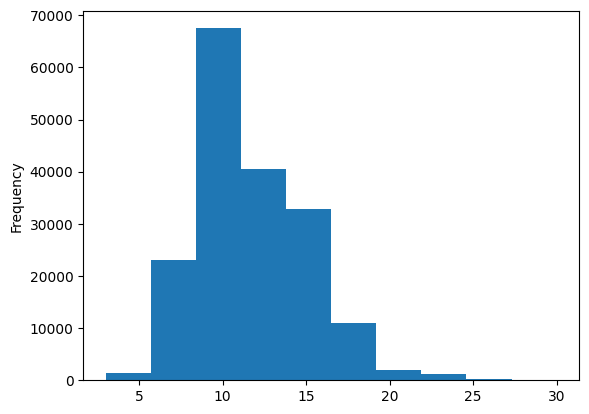

In [ ]:
train_df.total_lines.plot.hist()

In [15]:
train_sentences = train_df.text.to_list()
test_sentences = test_df.text.to_list()
val_sentences = val_df.text.to_list()

In [16]:
len(train_sentences), len(test_sentences), len(val_sentences)

(180040, 30135, 30212)

## Make numeric labels

In [200]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(sparse=False) #needs to be False as it is incompatible with TensorFlow

train_labels_one_hot = one_hot.fit_transform(train_df.target.to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot.transform(val_df.target.to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot.transform(test_df.target.to_numpy().reshape(-1, 1))
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [199]:
# Label encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df.target.to_numpy().reshape(-1, 1))
val_labels_encoded = label_encoder.transform(val_df.target.to_numpy().reshape(-1, 1))
test_labels_encoded = label_encoder.transform(test_df.target.to_numpy().reshape(-1, 1))

train_labels_encoded

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


array([3, 2, 2, ..., 4, 1, 1])

In [230]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Baseline Model (TF-IDF Multinomial Naive Bayes classifier)

In [207]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [208]:
# Creating a Pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit Pipeline to training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [209]:
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [210]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

To visualise the performance of a model, we should use the following metrics:

Accuracy, Precision, F1, Recall

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-09-17 08:33:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-17 08:33:44 (119 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [211]:
from helper_functions import calculate_results

In [212]:
baseline_results = calculate_results(val_labels_encoded, baseline_preds)

In [213]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 1: Conv1D with Embedding layer

In [214]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [215]:
# Finding out how long each sentence is on average
import numpy as np

sentence_lengths = [len(sentence.split()) for sentence in train_sentences]
np.mean(sentence_lengths)

26.338269273494777

(array([2.5486e+04, 7.1478e+04, 4.8888e+04, 2.0260e+04, 7.5560e+03,
        3.4370e+03, 1.4950e+03, 7.3700e+02, 3.2800e+02, 1.6500e+02,
        8.5000e+01, 4.9000e+01, 2.0000e+01, 1.5000e+01, 9.0000e+00,
        6.0000e+00, 8.0000e+00, 8.0000e+00, 3.0000e+00, 2.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1. ,  12.8,  24.6,  36.4,  48.2,  60. ,  71.8,  83.6,  95.4,
        107.2, 119. , 130.8, 142.6, 154.4, 166.2, 178. , 189.8, 201.6,
        213.4, 225.2, 237. , 248.8, 260.6, 272.4, 284.2, 296. ]),
 <BarContainer object of 25 artists>)

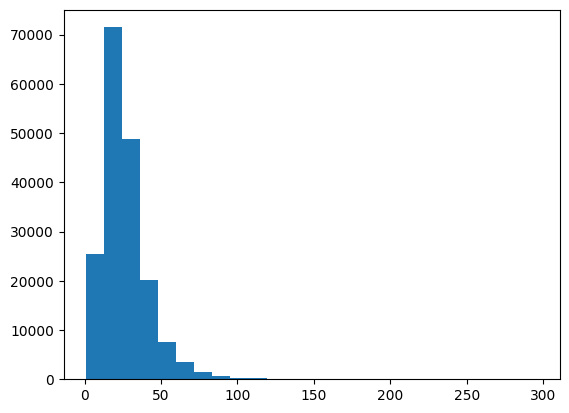

In [216]:
import matplotlib.pyplot as plt
plt.hist(sentence_lengths, bins=25)

In [217]:
output_seq_length = np.percentile(sentence_lengths, 95)
output_seq_length #95% of data have length 55 or less

55.0

In [218]:
max(sentence_lengths)

296

In [219]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, Embedding, Input, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

### Creating a TextVectorization layer
From the PubMed article, PubMed20k has 68k vocabulary (|V|)

In [220]:
max_tokens = 68000

In [221]:
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=int(output_seq_length),
                                    pad_to_max_tokens=True)

In [222]:
text_vectorizer.adapt(train_sentences)

In [223]:
import random
target = random.choice(train_sentences)
print(f'Target sentence: {target}')
print(f'Length: {len(target)}')
print(f'Vectorized: {text_vectorizer([target])}')

Target sentence: our secondary end point findings of a significant correlation between pik@ca mutation and response to letrozole-lapatinib in hr-positive/her@-negative early breast cancer must now be independently confirmed .
Length: 208
Vectorized: [[  246   151   199   294   310     4     8    37   789    30  7811  2321
      3   142     6 22684     5 55893   224   413   135  2989  2735    36
   1200   736     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [224]:
rct_20k_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_vocab)}')
print(f'Most common words: {rct_20k_vocab[:5]}')
print(f'Least common words: {rct_20k_vocab[-5:]}')

Number of words in vocab: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [225]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [226]:
embedding = Embedding(input_dim=len(rct_20k_vocab),
                      output_dim=64,
                      input_length=int(output_seq_length),
                      mask_zero=True, #handles datasets with large amounts of zero well
                      name="token_embedding_layer")

In [227]:
print(f'Before vectorization: {target}')

vectorized_sentence = text_vectorizer([target])
print(f'Vectorized: {vectorized_sentence}')

embedded_sentence = embedding(vectorized_sentence)
print(f'Embedded: {embedded_sentence}')
print(f'Embedded shape: {embedded_sentence.shape}')

Before vectorization: our secondary end point findings of a significant correlation between pik@ca mutation and response to letrozole-lapatinib in hr-positive/her@-negative early breast cancer must now be independently confirmed .
Vectorized: [[  246   151   199   294   310     4     8    37   789    30  7811  2321
      3   142     6 22684     5 55893   224   413   135  2989  2735    36
   1200   736     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Embedded: [[[-0.00938718  0.00450883  0.03639982 ... -0.02502401 -0.02885244
    0.04580188]
  [-0.0127674  -0.02907971 -0.00462181 ... -0.01064013  0.00326654
    0.01187623]
  [-0.00092615  0.02470157 -0.04385478 ...  0.02582499  0.00118643
    0.02501302]
  ...
  [ 0.03562104 -0.00312898 -0.00872852 ...  0.03109107  0.04628703
    0.01387298]
  [ 0.03562104 -0.00312898 -0.00872852 ...  0.03109107  0.04628703


### Creating datasets (make sure our data loads as fast as possible)

In [228]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [202]:
train_data_sentences = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [203]:
valid_dataset_sentences = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_sentences = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [231]:
inputs = Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = Conv1D(32, 5, activation="relu")(x)
x = Conv1D(32, 3, activation="relu")(x)
x = GlobalAveragePooling1D()(x)
outputs = Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name="Conv1D_model")

In [232]:
model_1.summary()

Model: "Conv1D_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding_layer (Emb  (None, 55, 64)            4149824   
 edding)                                                         
                                                                 
 conv1d_2 (Conv1D)           (None, 51, 32)            10272     
                                                                 
 conv1d_3 (Conv1D)           (None, 49, 32)            3104      
                                                                 
 global_average_pooling1d_1  (None, 32)               

In [233]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [234]:
history_1 = model_1.fit(train_data_sentences,
                        epochs=5,
                        steps_per_epoch=int(0.1*len(train_data_sentences)),
                        validation_data=valid_dataset_sentences,
                        validation_steps=int(0.1*len(valid_dataset_sentences)))

Epoch 1/5
562/562 [==============================] - 49s 73ms/step - loss: 0.9876 - accuracy: 0.5949 - val_loss: 0.7684 - val_accuracy: 0.6968
Epoch 2/5
562/562 [==============================] - 9s 15ms/step - loss: 0.7262 - accuracy: 0.7200 - val_loss: 0.7138 - val_accuracy: 0.7330
Epoch 3/5
562/562 [==============================] - 7s 12ms/step - loss: 0.6761 - accuracy: 0.7400 - val_loss: 0.6526 - val_accuracy: 0.7557
Epoch 4/5
562/562 [==============================] - 4s 8ms/step - loss: 0.6465 - accuracy: 0.7526 - val_loss: 0.6321 - val_accuracy: 0.7533
Epoch 5/5
562/562 [==============================] - 7s 13ms/step - loss: 0.6386 - accuracy: 0.7657 - val_loss: 0.6158 - val_accuracy: 0.7726


In [236]:
model_1_preds = model_1.predict(valid_dataset_sentences)

945/945 [==============================] - 5s 5ms/step


In [237]:
model_1_preds.shape

(30212, 5)

In [238]:
model_1_preds

array([[5.0487781e-01, 2.5032848e-01, 3.7421677e-02, 1.8867770e-01,
        1.8694276e-02],
       [5.1400775e-01, 2.8773257e-01, 7.9759108e-03, 1.8489154e-01,
        5.3922241e-03],
       [2.9107437e-01, 2.0805975e-02, 7.1996532e-04, 6.8738866e-01,
        1.1071429e-05],
       ...,
       [8.9117566e-05, 7.0174625e-03, 6.5842341e-03, 5.3804179e-05,
        9.8625541e-01],
       [9.9110037e-02, 2.2444899e-01, 3.6975953e-01, 8.3408244e-02,
        2.2327317e-01],
       [3.1132516e-01, 3.8928401e-01, 1.1043445e-01, 6.3194439e-02,
        1.2576196e-01]], dtype=float32)

In [239]:
model_1_preds = tf.argmax(model_1_preds, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 2, 1])>

In [240]:
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 77.13822322256057,
 'precision': 0.7783919164442306,
 'recall': 0.7713822322256058,
 'f1': 0.7701246050336924}

In [241]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Pretrained token embeddings from TF Hub for feature extraction
The paper initially used GloVe embedddings but we will stick with the USE pretrained embeddings

In [ ]:
import tensorflow_hub as hub
use_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                               trainable=False,
                               name="embedding_layer")

In [ ]:
target

'care staff could not be blinded for the intervention .'

In [ ]:
use_embedding([target]).shape

TensorShape([1, 512])

In [ ]:
inputs = Input(shape=[], dtype=tf.string)
x = use_embedding(inputs)
outputs = Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs)

In [ ]:
model_2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 embedding_layer (KerasLaye  (None, 512)               256797824 
 r)                                                              
                                                                 
 dense_17 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 256800389 (979.62 MB)
Trainable params: 2565 (10.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_2 = model_2.fit(train_dataset,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        epochs=5,
                        validation_steps=int(0.1*len(valid_dataset)),
                        validation_data=valid_dataset)

In [ ]:
model_2_preds = tf.argmax(model_2.predict(valid_dataset), axis=1)

In [ ]:
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

In [ ]:
model_1_results

## Model 3: Character-level embedding model

Now we'll explore `character-level` embeddings...

We've always been explore `token-level` embeddings but `character-level` embeddings tokenize every character instead of each word

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, Conv1D, Embedding
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
import random
target = random.choice(train_sentences)

In [ ]:
def split_chars(text):
  return " ".join(list(text))

In [ ]:
split_chars(target)

'a d d i t i o n a l l y   ,   j u n i o r   r e s i d e n t s   w h o   h a d   a c c e s s   t o   o u r   w e b s i t e   s h o w e d   a   s i g n i f i c a n t   i n c r e a s e   i n   t h e i r   g r a d e d   t e c h n i c a l   p e r f o r m a n c e   b y   @   p o i n t s   w h e n   c o m p a r e d   t o   r e s i d e n t s   w h o   d i d   n o t   h a v e   a c c e s s   t o   t h e   w e b s i t e   w h o   s h o w e d   a n   i m p r o v e m e n t   o f   o n l y   @   p o i n t s   (   p   =   @   )   .'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
#Finding average character length
import numpy as np
chars_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_len)
mean_char_len

149.3662574983337

(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3950e+02, 2.7800e+02, 4.1650e+02, 5.5500e+02,
        6.9350e+02, 8.3200e+02, 9.7050e+02, 1.1090e+03, 1.2475e+03,
        1.3860e+03]),
 <BarContainer object of 10 artists>)

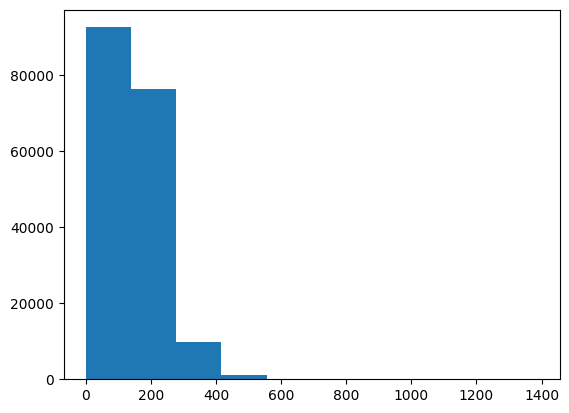

In [ ]:
import matplotlib.pyplot as plt
plt.hist(chars_len, bins=10)

In [ ]:
output_seq_len = int(np.percentile(chars_len, 95))
output_seq_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char level vectorizer
NUM_CHAR_TOKENS = len(alphabet)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_len,
                                    pad_to_max_tokens=True,
                                    #standardize=None,
                                    name="char_vectorizer")

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f'Length of vocab: {len(char_vocab)}')
print(f'5 most common chars: {char_vocab[:5]}')
print(f'5 least common chars: {char_vocab[-5:]}')

Length of vocab: 28
5 most common chars: ['', '[UNK]', 'e', 't', 'i']
5 least common chars: ['k', 'x', 'z', 'q', 'j']


In [ ]:
random_train_chars = random.choice(train_chars)
print(f'Charified text: {random_train_chars}\n')
print(f'Length of charified text: {len(random_train_chars)}\n')


vec_chars = char_vectorizer([random_train_chars])
print(f'Vectorized chars: {vec_chars}\n')
print(f'Shape of vectorized chars: {vec_chars.shape}')

Charified text: t h e   m a i n   o u t c o m e   m e a s u r e   w a s   r e b l e e d i n g   .

Length of charified text: 81

Vectorized chars: [[ 3 13  2 15  5  4  6  7 16  3 11  7 15  2 15  2  5  9 16  8  2 20  5  9
   8  2 22 12  2  2 10  4  6 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  

In [ ]:
char_embedding = Embedding(input_dim=len(char_vocab),
                           output_dim=25,
                           mask_zero=True,
                           name="char_embed")

In [ ]:
char_embedding(vec_chars)

<tf.Tensor: shape=(1, 290, 25), dtype=float32, numpy=
array([[[ 0.00313986,  0.02925089, -0.04811571, ..., -0.0023294 ,
          0.00897663, -0.00486265],
        [ 0.03073975, -0.01552276, -0.04336409, ...,  0.01000873,
         -0.03854394, -0.02181187],
        [ 0.00721694, -0.04630009, -0.02087988, ...,  0.01336807,
         -0.01268461,  0.03029274],
        ...,
        [-0.03094503,  0.00137296,  0.01984182, ..., -0.00993747,
         -0.02317122, -0.03032296],
        [-0.03094503,  0.00137296,  0.01984182, ..., -0.00993747,
         -0.02317122, -0.03032296],
        [-0.03094503,  0.00137296,  0.01984182, ..., -0.00993747,
         -0.02317122, -0.03032296]]], dtype=float32)>

In [ ]:
inputs = Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embedding(x)
x = Conv1D(32, 5, padding="same", activation="relu")(x)
x = Conv1D(32, 3, padding="same", activation="relu")(x)
x = GlobalAveragePooling1D()(x)
outputs = Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)

In [ ]:
model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d (Conv1D)             (None, 290, 32)           4032      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 32)           3104      
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                     

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_3 = model_3.fit(train_char_dataset,
                        steps_per_epoch=int(0.1*len(train_char_dataset)),
                        epochs=5,
                        validation_data=val_char_dataset,
                        validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 9s 10ms/step - loss: 1.4550 - accuracy: 0.3521 - val_loss: 1.3871 - val_accuracy: 0.3993
Epoch 2/5
562/562 [==============================] - 5s 8ms/step - loss: 1.3718 - accuracy: 0.4026 - val_loss: 1.3506 - val_accuracy: 0.4192
Epoch 3/5
562/562 [==============================] - 4s 7ms/step - loss: 1.3410 - accuracy: 0.4326 - val_loss: 1.3203 - val_accuracy: 0.4392
Epoch 4/5
562/562 [==============================] - 4s 7ms/step - loss: 1.2871 - accuracy: 0.4585 - val_loss: 1.2630 - val_accuracy: 0.4741
Epoch 5/5
562/562 [==============================] - 4s 8ms/step - loss: 1.2637 - accuracy: 0.4686 - val_loss: 1.2361 - val_accuracy: 0.4947


In [ ]:
model_3_preds = tf.argmax(model_3.predict(val_sentences), axis=1)

945/945 [==============================] - 3s 3ms/step


In [ ]:
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([4, 4, 4, ..., 4, 4, 4])>

In [ ]:
model_3_results = calculate_results(val_labels_encoded, model_3_preds)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_3_results

{'accuracy': 33.22189858334437,
 'precision': 0.29035785289072996,
 'recall': 0.33221898583344367,
 'f1': 0.178260840914946}

## Model 4: Token Embeddings + Character Embeddings

1. Create the Token Level Embedding
2. Create the Character Level Embedding
3. Combine both the embedding layers using the Concatenate layer
4. Build a series of output layers on top of the Concatenate layer
5. Input should be token and character sequences

In [ ]:
import tensorflow_hub as hub

token_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                 trainable=False,
                                 name="token_embedding_layer")

In [ ]:
# Set up token inputs
from tensorflow.keras.layers import Input, Dense

token_inputs = Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = token_embedding(token_inputs)
token_outputs = Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

In [ ]:
# Character Lavel model
from tensorflow.keras.layers import Bidirectional, LSTM

char_inputs = Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = Bidirectional(LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

In [ ]:
# Concatenate the token and char inputs (create hybrid token embedding)
from tensorflow.keras.layers import Concatenate, Dropout

token_char_cat = Concatenate(name="concatenation_layer")([token_model.output, char_model.output])

# Creating output layer
combined_dropout = Dropout(0.5)(token_char_cat)
combined_dense = Dense(128, activation="relu")(combined_dropout)

dropout_2 = Dropout(0.5)(combined_dense)
output_layer = Dense(num_classes, activation="softmax")(dropout_2)

# Constructing model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 token_embedding_layer (Ker  (None, 512)                  2567978   ['

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

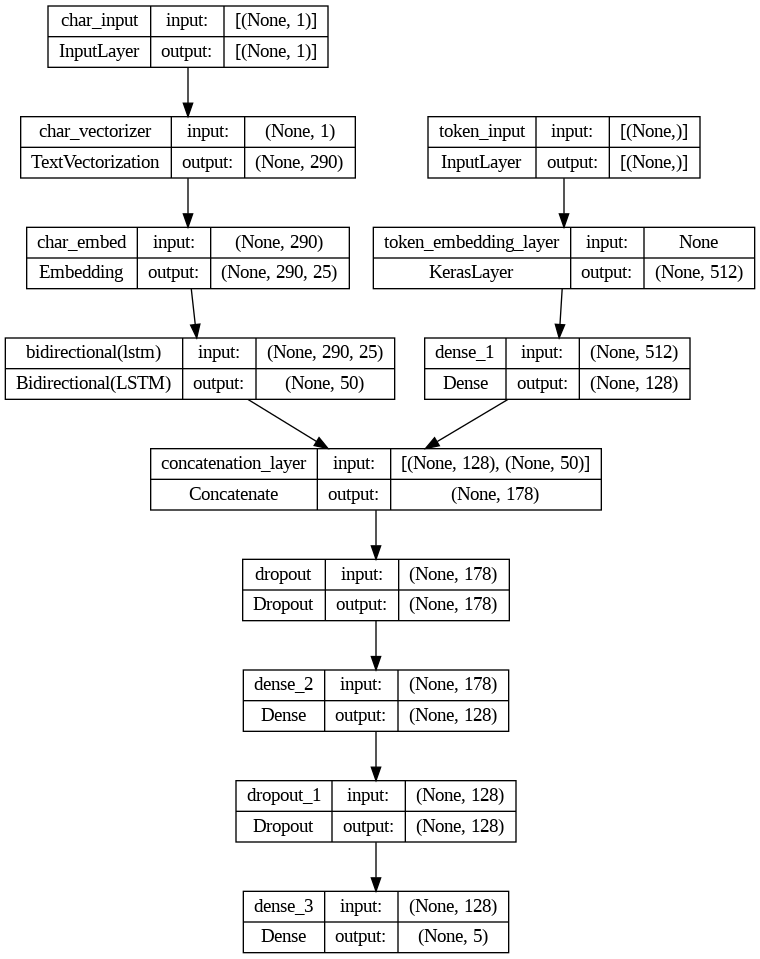

In [ ]:
tf.keras.utils.plot_model(model_4, show_shapes=True)

In [ ]:
train_data_concat = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_labels_concat = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_dataset_concat = tf.data.Dataset.zip((train_data_concat, train_labels_concat))

train_dataset_concat = train_dataset_concat.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_data_concat = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_labels_concat = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_dataset_concat = tf.data.Dataset.zip((val_data_concat, val_labels_concat))

val_dataset_concat = val_dataset_concat.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset_concat, val_dataset_concat

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_4 = model_4.fit(train_dataset_concat,
                        epochs=5,
                        steps_per_epoch=int(0.1*len(train_dataset_concat)),
                        validation_data=val_dataset_concat,
                        validation_steps=int(0.1*len(val_dataset_concat)))

Epoch 1/5
562/562 [==============================] - 47s 67ms/step - loss: 0.9871 - accuracy: 0.6039 - val_loss: 0.7777 - val_accuracy: 0.7011
Epoch 2/5
562/562 [==============================] - 29s 51ms/step - loss: 0.8031 - accuracy: 0.6926 - val_loss: 0.7233 - val_accuracy: 0.7217
Epoch 3/5
562/562 [==============================] - 26s 47ms/step - loss: 0.7777 - accuracy: 0.7037 - val_loss: 0.7012 - val_accuracy: 0.7277
Epoch 4/5
562/562 [==============================] - 30s 53ms/step - loss: 0.7471 - accuracy: 0.7169 - val_loss: 0.6749 - val_accuracy: 0.7400
Epoch 5/5
562/562 [==============================] - 27s 48ms/step - loss: 0.7540 - accuracy: 0.7147 - val_loss: 0.6690 - val_accuracy: 0.7427


In [ ]:
model_4_preds = model_4.predict(val_dataset_concat)

945/945 [==============================] - 22s 21ms/step


In [ ]:
model_4_preds = tf.argmax(model_4_preds, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 2, 1])>

In [ ]:
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'accuracy': 74.07983582682378,
 'precision': 0.7394889914700651,
 'recall': 0.7407983582682378,
 'f1': 0.7343365184331448}

## Model 5: Transfer Learning with **Character Embedding** + **Token Embedding** + **Positional Embedding**

We'll explore feature engineering - these features (line number, total lines for eg.) need to be available at test time

In [ ]:
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

### Create positional embeddings

In [ ]:
train_df.line_number.value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

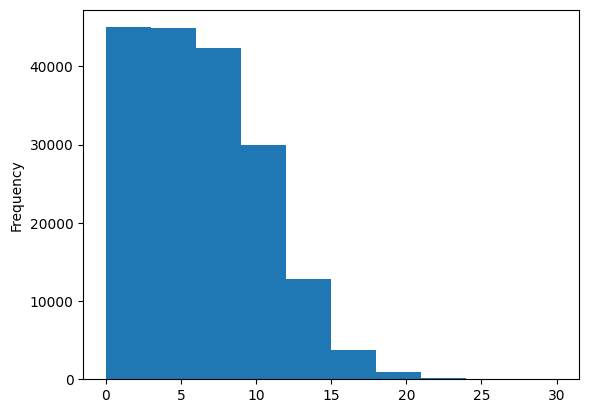

In [ ]:
train_df.line_number.plot.hist()

In [ ]:
# One-hot encode line numbers
train_line_numbers_one_hot = tf.one_hot(train_df.line_number.to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df.line_number.to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df.line_number.to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
total_lines = train_df.total_lines
total_lines

0         11
1         11
2         11
3         11
4         11
          ..
180035    11
180036    11
180037    11
180038    11
180039    11
Name: total_lines, Length: 180040, dtype: int64

<Axes: ylabel='Frequency'>

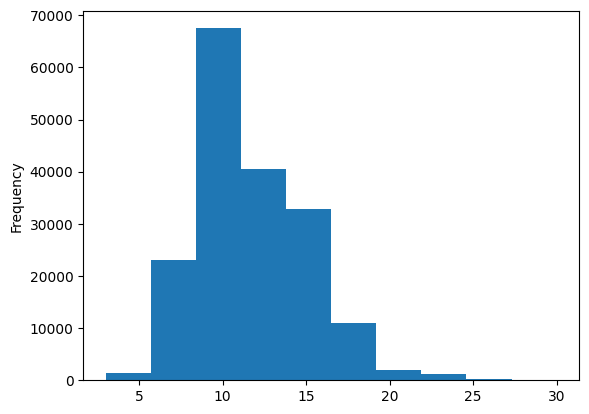

In [ ]:
total_lines.plot.hist()

In [ ]:
total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df.total_lines.to_numpy(), depth=18)
val_total_lines_one_hot = tf.one_hot(val_df.total_lines.to_numpy(), depth=18)
test_total_lines_one_hot = tf.one_hot(test_df.total_lines.to_numpy(), depth=18)
train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 18), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.]], dtype=float32)>,
 TensorShape([180040,

#### Steps to build our tribrid model

1. Token-level model
2. Character-level model
3. "line_number" feature model
4. "total_lines" feature model
5. Combine 1&2 using `tf.keras.layers.Concatenate`
6. Combine 3&4&5 using `tf.keras.layers.Concatenate`
7. Create output layer to accept tribrid embedding and output label probs
8. Combine inputs of 1, 2, 3 to pass into the model

In [ ]:
from tensorflow.keras.layers import Dense, Input, Bidirectional, LSTM, Concatenate, Dropout

In [ ]:
# Token-level model
token_inputs = Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = token_embedding(token_inputs)
token_outputs = Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs, name="token_embedding_model")

# Character-level model
char_inputs = Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vector = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vector)
char_bi_lstm = Bidirectional(LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm, name="char_embedding_model")

# Line number feature model
line_inputs = Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
line_outputs = Dense(32, activation="relu")(line_inputs)
line_number_model = tf.keras.Model(line_inputs, line_outputs)

# Total number feature model
total_lines_inputs = Input(shape=(18,), dtype=tf.float32, name="total_lines_inputs")
total_lines_outputs = Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_outputs)

# Concatenate token and character embedding model
token_char_embeddings = Concatenate(name="token_and_char_embedding")([token_model.output, char_model.output])

x = Dense(256, activation="relu")(token_char_embeddings)
x = Dropout(0.5)(x)

# Concatenating the remaining embeddings
tribrid_embeddings = Concatenate(name="token_char_positional_embedding")([x,
                                                                          line_number_model.output,
                                                                          total_lines_model.output])
# Output layers
y = Dense(128, activation="relu")(tribrid_embeddings)
y = Dropout(0.1)(y)
output_layer = Dense(num_classes, activation="softmax")(y)

# Input layers
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="tribrid_embedding_model")

In [ ]:
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 token_embedding_layer (Ker  (None, 512)                  2567978   ['token_

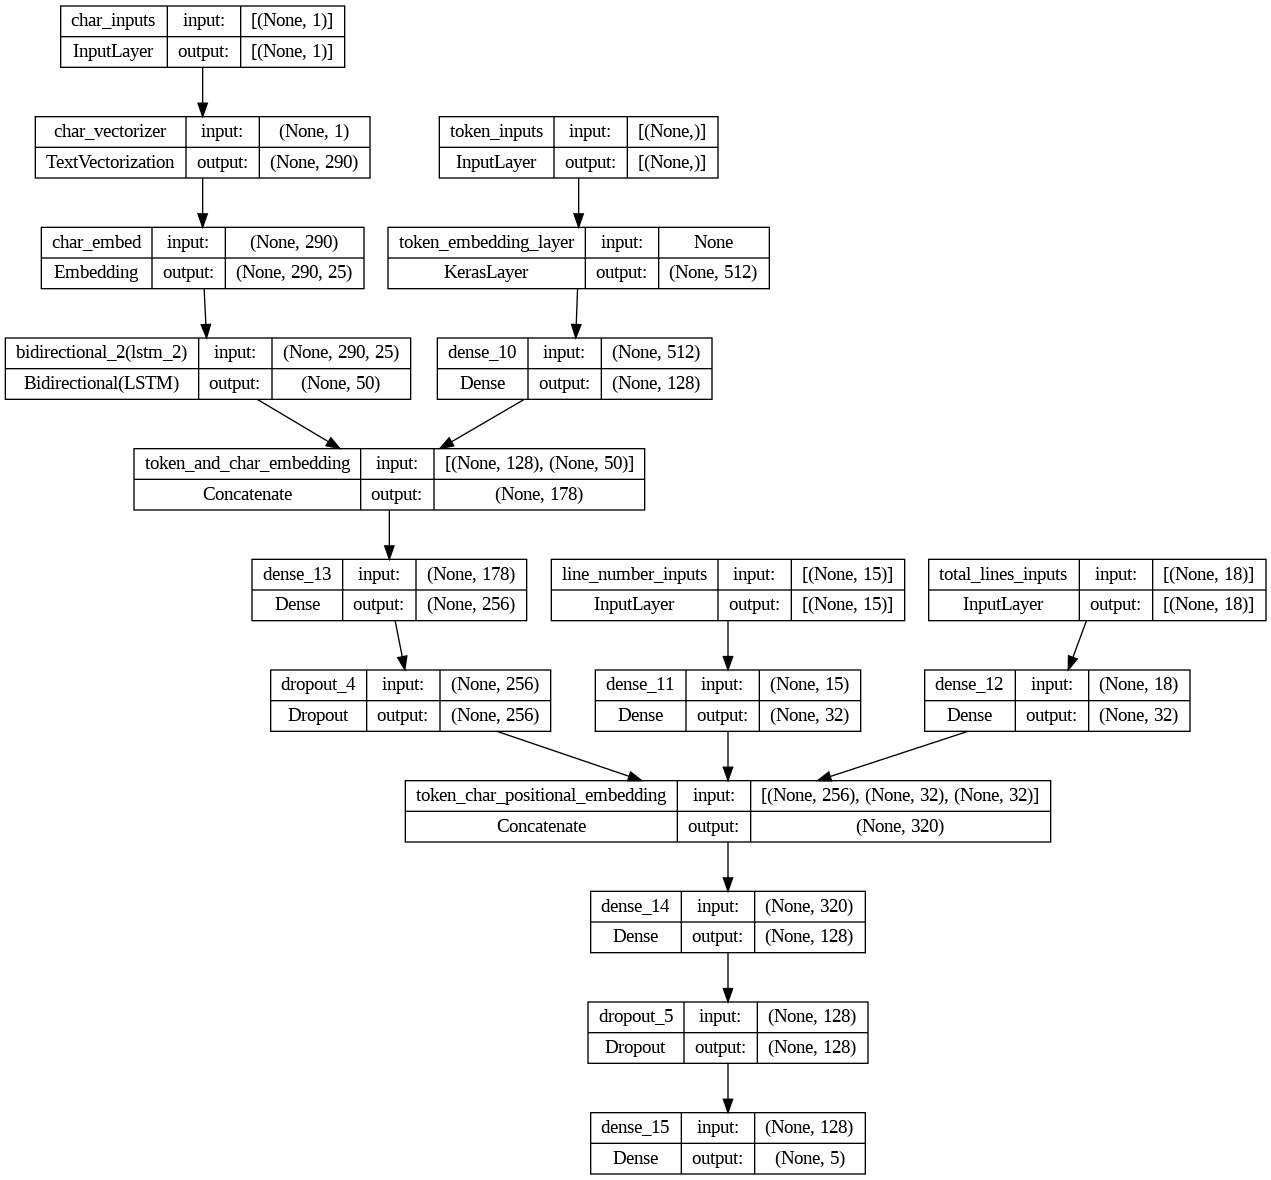

In [ ]:
tf.keras.utils.plot_model(model_5, show_shapes=True)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), #label_smoothing helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Label Smoothing - if our model gets too confident on a single class, it will get stuck on that class and not consider other classes

https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [ ]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [ ]:
train_line_numbers_one_hot[0], train_total_lines_one_hot[0]

(<tf.Tensor: shape=(15,), dtype=float32, numpy=
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)>,
 <tf.Tensor: shape=(18,), dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.], dtype=float32)>)

In [ ]:
# Creating the datasets

train_position_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                          train_total_lines_one_hot,
                                                          train_sentences,
                                                          train_chars
                                                          ))
train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_dataset = tf.data.Dataset.zip((train_position_data, train_labels))

val_position_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                        val_total_lines_one_hot,
                                                        val_sentences,
                                                        val_chars))
val_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_dataset = tf.data.Dataset.zip((val_position_data, val_labels))

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset, val_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_5 = model_5.fit(train_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        validation_data=val_dataset,
                        validation_steps=int(0.1*len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 47s 63ms/step - loss: 1.0560 - accuracy: 0.7443 - val_loss: 0.9443 - val_accuracy: 0.8221
Epoch 2/5
562/562 [==============================] - 26s 46ms/step - loss: 0.9357 - accuracy: 0.8277 - val_loss: 0.9094 - val_accuracy: 0.8491
Epoch 3/5
562/562 [==============================] - 24s 43ms/step - loss: 0.9143 - accuracy: 0.8367 - val_loss: 0.8954 - val_accuracy: 0.8497
Epoch 4/5
562/562 [==============================] - 27s 48ms/step - loss: 0.9024 - accuracy: 0.8510 - val_loss: 0.8853 - val_accuracy: 0.8564
Epoch 5/5
562/562 [==============================] - 26s 46ms/step - loss: 0.8958 - accuracy: 0.8525 - val_loss: 0.8806 - val_accuracy: 0.8551


In [ ]:
model_5_preds = tf.argmax(model_5.predict(val_dataset), axis=1)
model_5_preds

945/945 [==============================] - 33s 30ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(val_labels_encoded, model_5_preds)

In [ ]:
model_5_results

{'accuracy': 85.75731497418244,
 'precision': 0.8634328595279775,
 'recall': 0.8575731497418244,
 'f1': 0.8540370327306201}

## Comparing all our past results

In [ ]:
baseline_results, model_3_results, model_4_results, model_5_results

({'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294},
 {'accuracy': 33.22189858334437,
  'precision': 0.29035785289072996,
  'recall': 0.33221898583344367,
  'f1': 0.178260840914946},
 {'accuracy': 74.07983582682378,
  'precision': 0.7394889914700651,
  'recall': 0.7407983582682378,
  'f1': 0.7343365184331448},
 {'accuracy': 85.75731497418244,
  'precision': 0.8634328595279775,
  'recall': 0.8575731497418244,
  'f1': 0.8540370327306201})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_5.save("drive/MyDrive/skimlit_best_model")

In [ ]:
loaded_skimlit = tf.keras.models.load_model("drive/MyDrive/skimlit_best_model")

In [ ]:
loaded_pred_probs = tf.argmax(loaded_skimlit.predict(val_dataset), axis=-1)

945/945 [==============================] - 36s 34ms/step


In [ ]:
loaded_model_results = calculate_results(val_labels_encoded, loaded_pred_probs)

In [ ]:
model_5_results == loaded_model_results

True

## Evaluting the model
- Turning test samples into tf.data.Dataset
- Find the most wrong predictions

In [120]:
import tensorflow as tf
test_df

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8
...,...,...,...,...
30130,RESULTS,there was a statistically significant between-...,13,17
30131,RESULTS,there were no statistically significant betwee...,14,17
30132,RESULTS,there was no significant association between s...,15,17
30133,RESULTS,no adverse effects were reported .,16,17


In [121]:
test_df.target.value_counts()

METHODS        9897
RESULTS        9713
CONCLUSIONS    4571
BACKGROUND     3621
OBJECTIVE      2333
Name: target, dtype: int64

In [122]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
onehotencoder = OneHotEncoder(sparse=False)
test_line_no_onehot = tf.one_hot(test_df.line_number.to_numpy(), depth=15)
test_total_lines_onehot = tf.one_hot(test_df.total_lines.to_numpy(), depth=18)
test_labels_onehot = onehotencoder.fit_transform(test_df.target.to_numpy().reshape(-1, 1))
test_labels_encoded = label_encoder.fit_transform(test_df.target.to_numpy())

test_line_no_onehot, test_total_lines_onehot, test_labels_onehot, test_labels_encoded

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(<tf.Tensor: shape=(30135, 15), dtype=float32, numpy=
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(30135, 18), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)>,
 array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]]),
 array([0, 4, 4, ..., 4, 4, 1]))

In [123]:
test_sentences = test_df.text.to_numpy()
test_sentences[:5]

array(['this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
       'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
       'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
       'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .',
       "the percentage of patients with abnormal lfts decreased significantly from baseline to @-months ' follow-up ."],
      dtype=object)

In [124]:
def to_chars(text):
  return " ".join(list(text))

test_chars = [to_chars(sentence) for sentence in test_sentences]
test_chars[:5]

['t h i s   s t u d y   a n a l y z e d   l i v e r   f u n c t i o n   a b n o r m a l i t i e s   i n   h e a r t   f a i l u r e   p a t i e n t s   a d m i t t e d   w i t h   s e v e r e   a c u t e   d e c o m p e n s a t e d   h e a r t   f a i l u r e   (   a d h f   )   .',
 'a   p o s t   h o c   a n a l y s i s   w a s   c o n d u c t e d   w i t h   t h e   u s e   o f   d a t a   f r o m   t h e   e v a l u a t i o n   s t u d y   o f   c o n g e s t i v e   h e a r t   f a i l u r e   a n d   p u l m o n a r y   a r t e r y   c a t h e t e r i z a t i o n   e f f e c t i v e n e s s   (   e s c a p e   )   .',
 'l i v e r   f u n c t i o n   t e s t s   (   l f t s   )   w e r e   m e a s u r e d   a t   @   t i m e   p o i n t s   f r o m   b a s e l i n e   ,   a t   d i s c h a r g e   ,   a n d   u p   t o   @   m o n t h s   f o l l o w - u p   .',
 's u r v i v a l   a n a l y s e s   w e r e   u s e d   t o   a s s e s s   t h e   a s s o c i a t i o n   b e t w e 

In [135]:
test_inputs = tf.data.Dataset.from_tensor_slices((test_line_no_onehot, test_total_lines_onehot, test_sentences, test_chars))
test_labels = tf.data.Dataset.from_tensor_slices(test_labels_onehot)

test_dataset = tf.data.Dataset.zip((test_inputs, test_labels))
test_dataset

<_ZipDataset element_spec=((TensorSpec(shape=(15,), dtype=tf.float32, name=None), TensorSpec(shape=(18,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None)), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [137]:
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [127]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [133]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow/skimlit_best_model")

In [138]:
test_pred_probs = loaded_model.predict(test_dataset)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds

942/942 [==============================] - 33s 31ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

In [182]:
test_probs = tf.round(tf.reduce_max(test_pred_probs, axis=1)*100, 2)
test_probs

<tf.Tensor: shape=(30135,), dtype=float32, numpy=array([46., 70., 84., ..., 64., 68., 57.], dtype=float32)>

In [183]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import calculate_results

--2023-09-17 13:13:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-17 13:13:40 (72.6 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [184]:
calculate_results(test_labels_encoded, test_preds)

{'accuracy': 85.1866600298656,
 'precision': 0.8567436765063637,
 'recall': 0.851866600298656,
 'f1': 0.8482587684717185}

In [185]:
import pandas as pd

test_results = pd.DataFrame({"text": test_sentences,
                             "label": test_labels_encoded,
                             "prediction": test_preds,
                             "probability": test_probs})
test_results

,text,label,prediction,probability
0,this study analyzed liver function abnormaliti...,0,3,46.0
1,a post hoc analysis was conducted with the use...,4,2,70.0
2,liver function tests ( lfts ) were measured at...,4,2,84.0
3,survival analyses were used to assess the asso...,4,2,83.0
4,the percentage of patients with abnormal lfts ...,4,4,73.0
...,...,...,...,...
30130,there was a statistically significant between-...,4,4,84.0
30131,there were no statistically significant betwee...,4,4,79.0
30132,there was no significant association between s...,4,4,64.0
30133,no adverse effects were reported .,4,4,68.0


In [186]:
label_classes = label_encoder.classes_
label_classes

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [187]:
wrong_results = test_results[test_results.label != test_results.prediction].sort_values("probability", ascending=False)
wrong_results.label = label_classes[wrong_results.label]
wrong_results.prediction = label_classes[wrong_results.prediction]
wrong_results.head()

,text,label,prediction,probability
18190,providers were randomized into @ groups : se c...,RESULTS,METHODS,89.0
15316,@ .,BACKGROUND,METHODS,89.0
3574,the intervention was delivered to children ran...,RESULTS,METHODS,89.0
18188,a @-arm randomized trial was conducted over @ ...,RESULTS,METHODS,89.0
671,to determine whether the insulin resistance th...,METHODS,OBJECTIVE,89.0


## Functionizing the model
- Returning categorized abstracts from legitimate abstract inputs

In [180]:
import numpy as np
classes = ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']

def process_abstract(abstract, model, classes=classes):

  processed_abs = ""
  abstract = abstract.rstrip(".")
  abs_split = abstract.split(".")
  total_lines = len(abs_split)
  line_numbers = [i for i in range(total_lines)]
  total_lines = [total_lines] * total_lines

  total_lines = tf.constant(tf.one_hot(total_lines, depth=18), dtype=tf.float32)
  line_numbers = tf.constant(tf.one_hot(line_numbers, depth=15), dtype=tf.float32)
  chars = tf.constant([" ".join(text) for text in abs_split], dtype=tf.string)
  abs_tf_split = tf.constant(abs_split, dtype=tf.string)

  val_dataset = (line_numbers, total_lines, chars, abs_tf_split)
  preds = list(tf.argmax(model.predict(x=val_dataset), axis=1))

  for i, text in enumerate(abs_split):
    line = f'{classes[preds[i]]}:{text}'
    print(line)
    processed_abs += line

  return processed_abs


In [188]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

--2023-09-17 13:14:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-09-17 13:14:23 (38.8 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



In [190]:
import json

with open("skimlit_example_abstracts.json", "r") as f:
  sample_data = json.load(f)

sample_data = [sample["abstract"] for sample in sample_data]
sample_data

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
 "Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth. No sing

In [196]:
import random
sample = random.choice(sample_data)
processed_abs = process_abstract(sample, loaded_model)

1/1 [==============================] - 0s 37ms/step
BACKGROUND:Mental illness, including depression, anxiety and bipolar disorder, accounts for a significant proportion of global disability and poses a substantial social, economic and heath burden
METHODS: Treatment is presently dominated by pharmacotherapy, such as antidepressants, and psychotherapy, such as cognitive behavioural therapy; however, such treatments avert less than half of the disease burden, suggesting that additional strategies are needed to prevent and treat mental disorders
METHODS: There are now consistent mechanistic, observational and interventional data to suggest diet quality may be a modifiable risk factor for mental illness
METHODS: This review provides an overview of the nutritional psychiatry field
METHODS: It includes a discussion of the neurobiological mechanisms likely modulated by diet, the use of dietary and nutraceutical interventions in mental disorders, and recommendations for further research
METHOD